# QSP Angle Learning
Can we learn the phase angles for a qsp sequence to approximate functions using gradient descent.

Goal: generate optimal QSP/QSVT sequences given constraints, where these constraints follow one of two schema whose character changes the nature of the search problem: (1) a party desires a specific quantum response function on a particular subspace, and (2) a party desires a specific discrimination behavior against a training set of known form.

(1) essentially refers to approzimation of a continuous function


(2) Refers to a discrete set of input-output behavior.
Example problem: given a finite set of distinct $x_j \in [-1, 1]$, determine the minimal degree real polynomial of bounded norm which has roots $x_j$ and norm bounded by 1. If $W(x)$ has the form of $W(x_j)$ for some known set $x_j$, we can cancel the effect of $W(x_j)$.

For now, we assume no noise.

In [20]:
from qsp_layers import *

# visualization tools
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import scipy
import IPython

sns.set()

In [2]:
InteractiveShell = IPython.core.interactiveshell.InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def plot(history):
    plt.plot(history.history['loss'])
    plt.title("Learning QSP Angles")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.show()


## Make QSP circuit model with trainable $\Phi$

In [50]:
def make_qsp_model(poly_deg = 0):

    N = poly_deg
    q = cirq.GridQubit(0, 0)
    phis = [sympy.Symbol(f'phi{k}') for k in range(N + 1)]
    theta = [sympy.Symbol(f'th')]

    circuit = cirq.Circuit(cirq.rz(phis[0])(q))

    for k in range(1,N+1):
        c = cirq.Circuit(
            cirq.rx(theta[0])(q),
            cirq.rz(phis[k])(q)
        )
        circuit.append(c)
        
    controlled_qsp = HybridControlledPQC(circuit,operators = cirq.X(q),
                          controlled_symbol_names=theta,
                          native_symbol_names=phis)
    
    theta_in = tf.keras.Input(shape=(1,),
                            dtype=tf.float32,
                        name='theta')
    measurement = controlled_qsp(theta_in)

    return tf.keras.Model(inputs=theta_in, outputs=measurement), circuit

## Testing QSP angle estimation

This strategy for testing phases is designed for constructing polynomials with discrete properties. E.g. roots

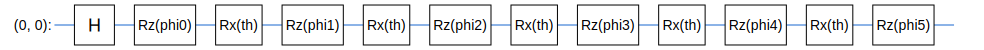

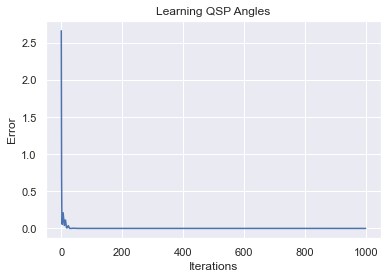

<AxesSubplot:xlabel='theta', ylabel='Z op'>

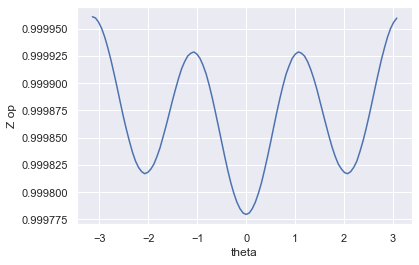

In [9]:
model, circuit = make_qsp_model(5)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[np.pi/4],[3*np.pi/4]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1],[1]], dtype=np.float32)

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(-np.pi,np.pi,np.pi/50)
out = tf.reshape(model.predict(all_th), (len(all_th,)))

sns.lineplot(x='theta',y='Z op',data={'theta': all_th,'Z op': out})


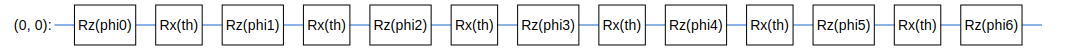

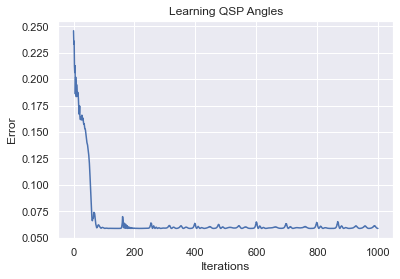

<AxesSubplot:xlabel='theta', ylabel='Z op'>

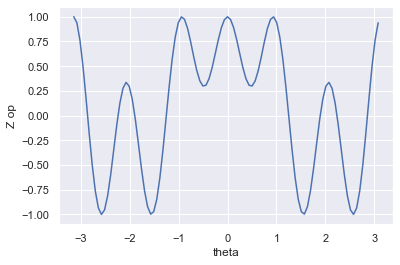

In [13]:
model, circuit = make_qsp_model(6)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[0],[0.5],[0.7],[1.9]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1],[0],[1],[0]], dtype=np.float32)

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(-np.pi,np.pi,np.pi/50)
out = tf.reshape(model.predict(all_th), (len(all_th,)))

sns.lineplot(x='theta',y='Z op',data={'theta': all_th,'Z op': out})


## We attempt to use this method to approximate a continuous function.

Our strategy is to sample a discrete set of points from our desired function to then train the model. The error is very sensitive to the polynomial degree. 

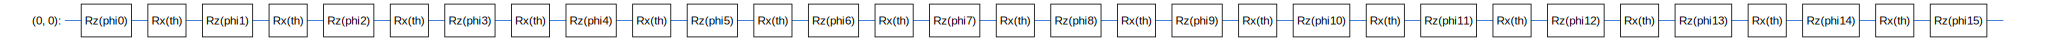

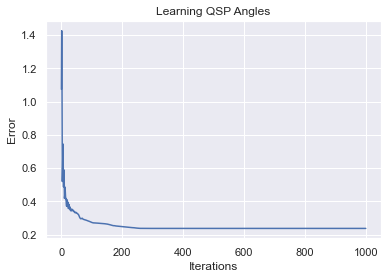

<AxesSubplot:xlabel='theta', ylabel='vals'>

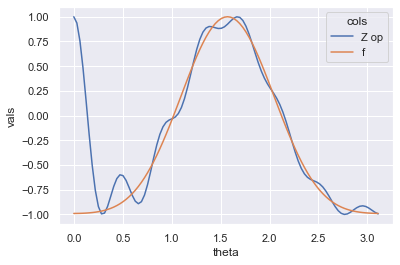

<AxesSubplot:xlabel='x', ylabel='vals'>

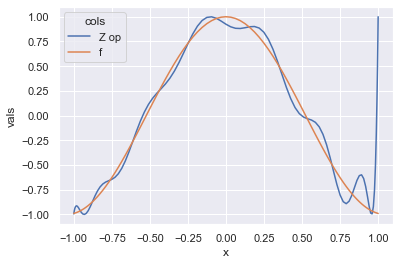

In [21]:
model, circuit = make_qsp_model(15)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


f = lambda x: np.cos(3*x)

# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectation value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(0,np.pi,np.pi/100)
out = tf.reshape(model.predict(all_th), (len(all_th,)))
df = pd.DataFrame({'theta': all_th,'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('theta', var_name='cols',  value_name='vals')
sns.lineplot(x='theta', y="vals", hue='cols', data=df)
plt.show() 

df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)

## Moore-Penrose Pseudoinverse
An $\frac{\epsilon}{3}$-approximation of $\frac{\delta}{2x}$ on domain $[-1,1] \setminus (-\frac{\delta}{2},\frac{\delta}{2})$.

Require $0 <   \epsilon \leq \delta \leq \frac{1}{2}$.


See Gilyen 2018 Thm 41.


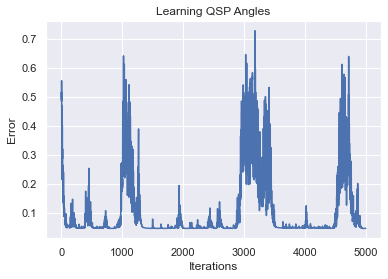

<AxesSubplot:xlabel='theta', ylabel='vals'>

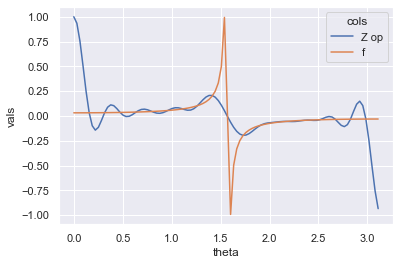

<AxesSubplot:xlabel='x', ylabel='vals'>

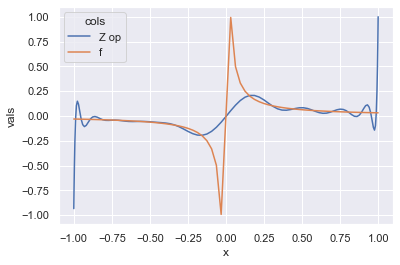

In [24]:
d = 1/16
e = 1/16
k = 2/d
poly_deg = int((np.log(1/e) / d))
b = np.ceil(k * k * np.log(k/e))
# let's just work with odd polys for now
poly_deg = poly_deg if (np.mod(poly_deg,2) == 1) else (poly_deg + 1)

# approximation to inverse function d/2x
f = lambda x: np.where(x!=0, d / 2 * (1 - (1 - x ** 2) ** b )/ x, 0)



model, circuit = make_qsp_model(poly_deg)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

    
# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectati/on value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=5000,
    verbose=0)

plot(history)



df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)

In [28]:
model.trainable_weights

[<tf.Variable 'parameters:0' shape=(46,) dtype=float32, numpy=
 array([ 35.30405  , -13.7089405,   5.547995 ,  -5.903225 ,  35.734474 ,
          5.847201 , -12.129799 ,  -6.492646 ,   0.1178837, -10.716333 ,
        -35.9274   ,  11.57694  , -26.316994 ,  -2.834805 ,  -3.0239985,
         25.22024  ,  -5.2181087,  11.464012 , -23.094841 ,  15.651888 ,
         20.661606 , -10.718232 , -28.545065 ,  40.059998 , -16.238655 ,
         27.96737  ,  21.456211 ,  10.154708 ,   7.787817 ,  50.43048  ,
        -19.98443  , -10.943197 ,  -2.762984 ,  37.81553  , -17.501059 ,
         35.518032 ,  -4.5620866,   5.3760567,   7.553923 , -13.00285  ,
        -17.164352 , -16.960272 , -15.468642 ,  -0.9980511,   1.6774459,
         32.85567  ], dtype=float32)>]

### X operator measurement (instead of Z above)

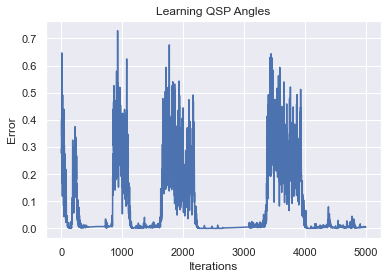

<AxesSubplot:xlabel='x', ylabel='vals'>

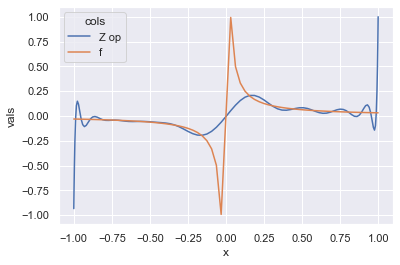

In [34]:
d = 1/16
e = 1/16
k = 2/d
poly_deg = int((np.log(1/e) / d))
b = np.ceil(k * k * np.log(k/e))
# let's just work with odd polys for now
poly_deg = poly_deg if (np.mod(poly_deg,2) == 1) else (poly_deg + 1)

# approximation to inverse function d/2x
f = lambda x: np.where(x!=0, d / 2 * (1 - (1 - x ** 2) ** b )/ x, 0)



model, circuit = make_qsp_model(poly_deg)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

    
# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectati/on value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=5000,
    verbose=0)

plot(history)



df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)

In [1]:
N = 20
q = cirq.GridQubit(0, 0)
phis = [sympy.Symbol(f'phi{k}') for k in range(N + 1)]
theta = [sympy.Symbol(f'th')]



# start = |+>
target = cirq.X(q)


circuit = cirq.Circuit(cirq.H(q),cirq.rz(phis[0])(q))

for k in range(1,N+1):
    c = cirq.Circuit(
        cirq.rx(theta[0])(q),
        cirq.rz(phis[k])(q)
    )
    circuit.append(c)

controlled_qsp = HybridControlledPQC(circuit,operators = target,
                      controlled_symbol_names=theta,
                      native_symbol_names=phis)

theta_in = tf.keras.Input(shape=(1,),
                        dtype=tf.float32,
                    name='theta')
measurement = controlled_qsp(theta_in)



model = tf.keras.Model(inputs=theta_in, outputs=measurement)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


f = lambda x: np.where(x < -0.1,1,np.where(x>0.1,1,0))

# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectation value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(0,np.pi,np.pi/100)
out = tf.reshape(model.predict(all_th), (len(all_th,)))
df = pd.DataFrame({'theta': all_th,'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('theta', var_name='cols',  value_name='vals')
sns.lineplot(x='theta', y="vals", hue='cols', data=df)
plt.show() 

df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)


NameError: name 'cirq' is not defined

[[-0.99861953+2.77555756e-16j]] [[-0.99861954-0.05252637j -0.        +0.j        ]
 [-0.        +0.j         -0.99861954+0.05252637j]]
[[-0.99732276-0.04807343j]] [[-0.99732277-0.05167412j  0.01913195-0.04807343j]
 [-0.01913195-0.04807343j -0.99732277+0.05167412j]]
[[-0.99344008-0.0960534j]] [[-0.99344008-0.0491534j   0.03787471-0.09605341j]
 [-0.03787471-0.09605341j -0.99344008+0.0491534j ]]
[[-0.98699813-0.14383003j]] [[-0.98699814-0.04507076j  0.05582318-0.14383003j]
 [-0.05582318-0.14383003j -0.98699814+0.04507076j]]
[[-0.97805351-0.19126096j]] [[-0.97805351-0.03959851j  0.07254335-0.19126096j]
 [-0.07254335-0.19126096j -0.97805351+0.03959851j]]
[[-0.96670943-0.23815637j]] [[-0.96670943-0.032967j    0.0875648 -0.23815637j]
 [-0.0875648 -0.23815637j -0.96670943+0.032967j  ]]
[[-0.95313638-0.2842653j]] [[-0.95313638-0.0254544j   0.100381  -0.28426531j]
 [-0.100381  -0.28426531j -0.95313638+0.0254544j ]]
[[-0.93759386-0.32926391j]] [[-0.93759387-0.01737428j  0.11045885-0.32926391j]
 [

[[0.96858717-0.18872517j]] [[ 0.96858718+0.05659144j  0.15172045-0.18872517j]
 [-0.15172045-0.18872517j  0.96858718-0.05659144j]]
[[0.99275441-0.06769739j]] [[ 0.99275441+0.03565144j  0.09265377-0.0676974j ]
 [-0.09265377-0.0676974j   0.99275441-0.03565144j]]
[[0.99810451+0.05295131j]] [[ 0.99810452+0.01128989j  0.02925867+0.05295131j]
 [-0.02925867+0.05295131j  0.99810452-0.01128989j]]
[[0.98458437+0.17107041j]] [[ 0.98458437-0.0147185j  -0.03334505+0.17107041j]
 [ 0.03334505+0.17107041j  0.98458437+0.0147185j ]]
[[0.95350341+0.28467347j]] [[ 0.95350342-0.04042193j -0.09032339+0.28467347j]
 [ 0.09032339+0.28467347j  0.95350342+0.04042193j]]
[[0.90741623+0.39194471j]] [[ 0.90741623-0.0638275j  -0.13748153+0.39194471j]
 [ 0.13748153+0.39194471j  0.90741623+0.0638275j ]]
[[0.84991209+0.49124292j]] [[ 0.84991209-0.08304604j -0.17156103+0.49124292j]
 [ 0.17156103+0.49124292j  0.84991209+0.08304604j]]
[[0.78532915+0.58110591j]] [[ 0.78532915-0.09643532j -0.19045805+0.58110591j]
 [ 0.1904580

'from unitary'

<AxesSubplot:xlabel='x', ylabel='vals'>

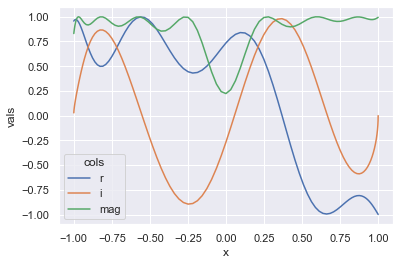

'from exp'

<AxesSubplot:xlabel='x', ylabel='exp'>

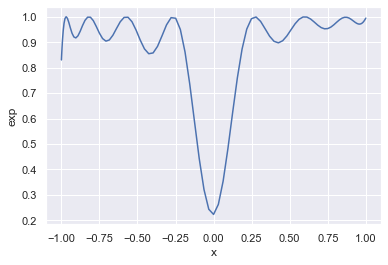

'eigenvalues'

array([ 0.78307761+0.62192399j, -0.78307761+0.62192399j])

<AxesSubplot:xlabel='r', ylabel='i'>

(0, 0): ───H───Rz(0.607π)───Rx(0.25π)───Rz(0.535π)───Rx(0.25π)───Rz(1.9π)───Rx(0.25π)───Rz(0.181π)───Rx(0.25π)───Rz(1.69π)───Rx(0.25π)───Rz(1.9π)───Rx(0.25π)───Rz(1.66π)───Rx(0.25π)───Rz(0.125π)───Rx(0.25π)───Rz(-0.298π)───Rx(0.25π)───Rz(0.55π)───Rx(0.25π)───Rz(1.68π)───Rx(0.25π)───Rz(-1.12π)───Rx(0.25π)───Rz(1.84π)───Rx(0.25π)───Rz(1.6π)───Rx(0.25π)───Rz(0)───Rx(0.25π)───Rz(-0.33π)───Rx(0.25π)───Rz(-0.05π)───Rx(0.25π)───Rz(1.84π)───Rx(0.25π)───Rz(1.87π)───Rx(0.25π)───Rz(-0.15π)───Rx(0.25π)───Rz(1.33π)───


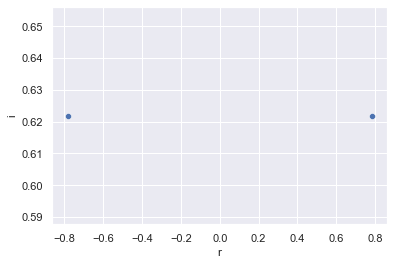

In [89]:
# Test 
th_in = np.arange(0,np.pi,np.pi/100)
phis = model.trainable_weights[0].numpy()
px = []
exp = []
for th_test in th_in: #th_in:
    # sns.scatterplot(data={'r':np.real(ev), 'i':np.imag(ev)},x='r',y='i')
    # print(qft)
    q = cirq.GridQubit(0, 0)
    qsp = cirq.Circuit(cirq.rz(phis[0])(q))

    for k in range(1,N+1):
        c = cirq.Circuit(
            cirq.rx(th_test)(q),
            cirq.rz(phis[k])(q)
        )
        qsp.append(c)
        
    
    qsp_u = qsp.unitary()
    #px.append(qsp_u[0,0])
    
    e = np.dot([[0.70710678,0.70710678]], np.dot(qsp_u,[[0.70710678],[0.70710678]]))
    print(e, qsp_u)
    px.append(e[0,0])
    
    qsp_exp = cirq.Circuit(cirq.H(q))
    qsp_exp.append(qsp)
    expectation_layer = tfq.layers.Expectation()
    output = expectation_layer(
        qsp_exp, operators = cirq.X(q))
    exp.append(output.numpy()[0,0])

'from unitary'
df = pd.DataFrame({'x':np.cos(th_in), 'r':np.real(px), 'i':np.imag(px),'mag': 2*np.absolute(px) **2 - 1})
df = df.melt('x', var_name='cols', value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)
plt.show()

'from exp'
df = pd.DataFrame({'x':np.cos(th_in), 'exp': exp})
sns.lineplot(x='x', y="exp", data=df)
plt.show()
'eigenvalues'
ev = scipy.linalg.eigvals(grover_u)
ev

sns.scatterplot(data={'r':np.real(ev), 'i':np.imag(ev)},x='r',y='i')
print(grover)



In [60]:
bit = cirq.GridQubit(0, 0)
ops = [cirq.Z(bit), cirq.X(bit) ]
c=  cirq.Circuit(
        cirq.H((bit)
    )
expectation_layer = tfq.layers.Expectation()
output = expectation_layer(
    c, operators = ops)
c.unitary()
output

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.        , 0.99999994]], dtype=float32)>